<a href="https://colab.research.google.com/github/AndreaMarini01/NLP_tasks/blob/main/NewNLP(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install nltk
%pip install scikit-learn
%pip install tensorflow
%pip install imbalanced-learn

# **Caricamento del dataset da Kaggle**

In [ ]:
import os
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("thedevastator/hate-speech-and-offensive-language-detection")
file_path = os.path.join(path, "train.csv")

df = pd.read_csv(file_path)
df.head()

100%|██████████| 963k/963k [00:00<00:00, 20.6MB/s]

Extracting files...


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# **Verifica della distribuzione delle classi**

Conteggio degli elementi per classe:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


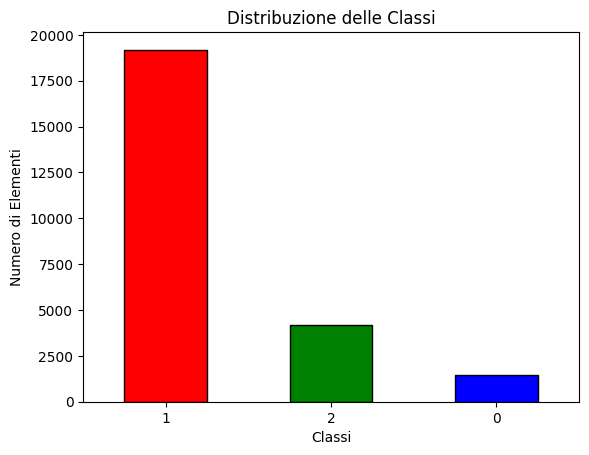

In [ ]:
import matplotlib.pyplot as plt

# Classe 0: Hate speech
# Classe 1: Offensive language
# Classe 2: Neither hate nor offensive

# Conta il numero di elementi per classe
class_counts = df['class'].value_counts()

# Mostra i conteggi
print("Conteggio degli elementi per classe:")
print(class_counts)

# Visualizza i conteggi in un grafico a barre
class_counts.plot(kind='bar', color=['red', 'green', 'blue'], edgecolor='black')
plt.title("Distribuzione delle Classi")
plt.xlabel("Classi")
plt.ylabel("Numero di Elementi")
plt.xticks(rotation=0)
plt.show()

# **Pulizia e Lemmatizzazione del testo della colonna "Tweet"**

In [ ]:
from nltk import word_tokenize
import nltk
import os
from nltk.stem import WordNetLemmatizer
import re

# Imposta una directory locale per il download
nltk_data_dir = './nltk_data'
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Scarica le stopwords forzando il percorso
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)

# Aggiungi manualmente il percorso alla ricerca di NLTK
nltk.data.path.append(nltk_data_dir)

from nltk.corpus import stopwords
stopword_set = stopwords.words('english')

def remove_stopword_lemmatize(sent):
    # Scarica il corpus WordNet di NLTK, necessario per la lemmatizzazione
    nltk.download('wordnet', quiet=True)
    lemma = WordNetLemmatizer()
    # Tokenizza la frase sent in una lista di parole usando word_tokenize di NLTK
    sent = word_tokenize(sent)
    new_sent = ''
    for word in sent:
        if word not in stopword_set:
            # Aggiunge solo la parola lemmatizzata
            # es. "running" -> "run"
            new_sent += lemma.lemmatize(word, pos='v') + ' '
    return new_sent.strip()

def clean_tweet(x):
    pattern = r'@\w*\b'
    no_pattern = r'&#\w*\b'
    x = re.sub(no_pattern,'',x)
    x = re.sub(pattern,'',x)
    x = x.replace('RT ','')
    x = x.replace('NFN ','')
    x = re.sub('[|!|:|"|;|\\\'|\\.]', '', x)
    return x

df['tweet'] = df['tweet'].apply(clean_tweet)
df['tweet'] = df['tweet'].apply(remove_stopword_lemmatize)

df.head()

[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,As woman shouldnt complain clean house & amp m...
1,3,0,3,0,1,boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2,3,0,3,0,1,Dawg You ever fuck bitch start cry ? You confu...
3,3,0,2,1,1,look like tranny
4,6,0,6,0,1,The shit hear might true might faker bitch tel...


# **Dati da includere nel training set**

In [ ]:
# Filtro per escludere righe vuote nella colonna 'tweet'
filtered_df = df[df['tweet'] != '']
# Seleziona solo la colonna 'tweet' per train_data
train_data = filtered_df[['tweet']]
# Seleziona le etichette corrispondenti
labels = filtered_df['class']

train_data.head()

,tweet
0,As woman shouldnt complain clean house & amp m...
1,boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2,Dawg You ever fuck bitch start cry ? You confu...
3,look like tranny
4,The shit hear might true might faker bitch tel...


# **Divisione tra training e test set**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data['tweet'], labels, test_size=0.2, random_state=42)

# Converti x_train e x_test in array 1D di stringhe
x_train = x_train.squeeze()  # Rimuove dimensioni extra se presenti
x_test = x_test.squeeze()

# **Conteggio di parole**

In [ ]:
# max_length: lunghezza massima (in termini di parole) di una frase/tweet
# total_word: numero totale di parole uniche presenti nel dataset

def get_max_len(t):
    max_len = 0
    total_words = []
    for i in t:
        max_len = max(max_len,len(i.split(' ')))
        total_words.extend(i.split(' '))
    return max_len,len(set(total_words))

max_len,total_words = get_max_len(list(train_data['tweet']))
max_len,total_words

(40, 27986)

# **Vettorizzazione ed Embedding delle frasi**

In [ ]:
from tensorflow.keras.layers import TextVectorization,Embedding
import tensorflow
import numpy as np
tensorflow.random.set_seed(42)

text_vector = TextVectorization(max_tokens=total_words,
                                output_mode = 'int',
                                output_sequence_length = max_len,
                                split = 'whitespace',
                                standardize = 'lower_and_strip_punctuation')

text_embedding = Embedding(input_dim = total_words,
                           input_length = max_len,
                           output_dim=128)

text_vector.adapt(x_train)

# Vettorizzazione dei dati
x_train_vectorized = text_vector(x_train).numpy()
x_test_vectorized = text_vector(x_test).numpy()

x_train_vectorized = np.expand_dims(x_train_vectorized, axis=-1)
x_test_vectorized = np.expand_dims(x_test_vectorized, axis=-1)

# Converte y_train e y_test in array di interi
y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **Caricamento del modello**

In [ ]:
from keras.src.optimizers import Adam
from tensorflow.keras.layers import LSTM,Input,Dense,Dropout

# Input compatibile con sequenze numeriche vettorializzate
input = Input(shape=(max_len, 1), dtype='int32')
from tensorflow.keras import regularizers

x = LSTM(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(input)
x = Dropout(0.5)(x)
x = Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = tensorflow.keras.Model(input, output, name='LSTM_model')

# Imposta un learning rate ridotto
optimizer = Adam(learning_rate=0.0003)

# Compila il modello con l'optimizer personalizzato
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,315 (5.14 KB)

 Trainable params: 1,315 (5.14 KB)

 Non-trainable params: 0 (0.00 B)

# **Gestione del problema di class imbalance: assegnamento del peso alle classi**

Epoch 1/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.2689 - loss: 1.1964 - val_accuracy: 0.7732 - val_loss: 1.0241
Epoch 2/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5012 - loss: 1.0917 - val_accuracy: 0.7277 - val_loss: 1.0247
Epoch 3/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5336 - loss: 1.0645 - val_accuracy: 0.7730 - val_loss: 0.9712
Epoch 4/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5802 - loss: 1.0590 - val_accuracy: 0.7238 - val_loss: 0.9890
Epoch 5/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6079 - loss: 1.0434 - val_accuracy: 0.7266 - val_loss: 0.9643
Epoch 6/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6478 - loss: 1.0252 - val_accuracy: 0.7087 - val_loss: 0.9521
Epoch 7/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6587 - loss: 1.0077 - val_accuracy: 0.7097 - val_loss: 0.9163
Epoch 8/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6749 - loss: 0.9959 - val_accu

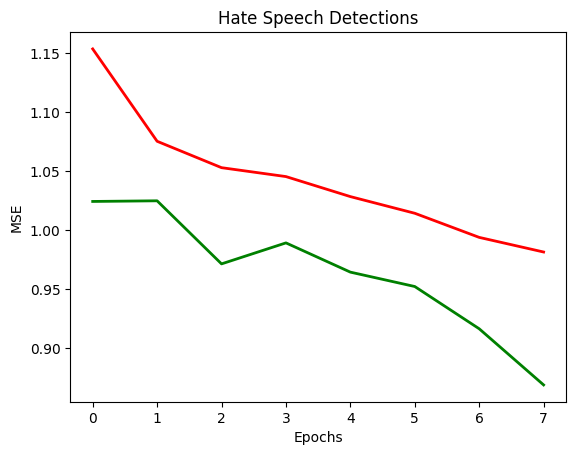

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Calcola i pesi delle classi
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Crea un dizionario dei pesi
# Trova le classi univoche in y_train
classes = np.unique(y_train)

# Crea un dizionario dei pesi con le classi corrette
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(class_weights))}

early_stopping = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)

# Aggiungi i pesi al fit del modello
model_history = model.fit(
    x_train_vectorized, y_train,
    epochs=8,
    batch_size=32,
    class_weight=class_weights_dict,  # Passa i pesi delle classi
    validation_data=(x_test_vectorized, y_test),
    callbacks=[early_stopping]
)

hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech Detections')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

# **Valutazione sul test set**

In [ ]:
# Valutazione sul set di test
test_loss, test_accuracy = model.evaluate(x_test_vectorized, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predizioni
predictions = model.predict(x_test_vectorized)
predicted_classes = predictions.argmax(axis=1)

# Report di classificazione
from sklearn.metrics import classification_report
print("Report di Classificazione:")
print(classification_report(y_test, predicted_classes))

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7239 - loss: 0.8750
Test Loss: 0.8687
Test Accuracy: 0.7289
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Report di Classificazione:
              precision    recall  f1-score   support

           0       0.09      0.13      0.11       287
           1       0.85      0.86      0.85      3851
           2       0.42      0.34      0.38       819

    accuracy                           0.73      4957
   macro avg       0.45      0.44      0.45      4957
weighted avg       0.73      0.73      0.73      4957

